### Imports and CUDA

In [1]:
# Matplotlib
import requests
import matplotlib.pyplot as plt
# Numpy
import numpy as np
# Torch
import torch
import torch.nn as nn

import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

import pandas as pd

# Misc
from tqdm import tqdm
import os

In [2]:
# Use GPU if available, else use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


### Run this if using Wandb for Hyperparameter Tuning, else do not run this

In [3]:
import wandb
wandb.login()

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: darrenchanyuhao (darrenchanyuhao-singapore-university-of-technology-and-d) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

### Objective

#### To develop a model that predicts taxi availability within a specific area for the next three hours. This means that if the model is run at 12 PM, it will provide predicted taxi availability for 1 PM, 2 PM, and 3 PM.

The area of interest is defined by the following geographical boundaries:

    North: 1.35106
    South: 1.32206
    East: 103.97839
    West: 103.92805

To identify the taxis currently available within this region, we use the TaxiAvailabilityScript.py.

This script collects real-time data, which serves as input for our predictive model.

By leveraging historical taxi availability trends and real-time data, our model aims to provide accurate forecasts, helping commuters, ride-hailing services, and urban planners make informed decisions.


# **To-Do List for Taxi Availability Prediction**

## **Step 1: Cleaning the Taxi Availability Data**
The first step involves retrieving and preprocessing the taxi availability dataset. The dataset consists of the following columns:

1. **DateTime**  
2. **Taxi Available Throughout Singapore**  
3. **Taxi Available in Selected Box Area**  
4. **Coordinates[]**  

For our specific use case, **the coordinates column will not be used for now**.  

To prepare the data for the neural network:  
- **Inputs:** We will use `DateTime` and `Taxi Available Throughout Singapore` as features.  
- **Output:** `Taxi Available in Selected Box Area` will be the target variable.  
- **DateTime Conversion:** Since `DateTime` is not in a format suitable for neural networks, we will extract relevant features:
  - **IsWeekend**: A binary feature (1 if it's a weekend, 0 otherwise).  
  - **Hour**: Transformed into a numerical value between **1 and 24** (avoiding 0, which may cause training issues).  

---

## **Step 2: Adding Additional Features**  
*(Partially completed; will be refined over time)*  

Aside from the existing columns, we aim to incorporate additional features that may improve prediction accuracy:  

1. **ERP Rates (Electronic Road Pricing) at the given time and location**  
   - Uncertain if this will significantly impact predictions. Further analysis is needed.  

2. **Number of LTA (Land Transport Authority) gantry locations**  
   - Again, its usefulness remains uncertain—further evaluation required.  

3. **Traffic Incidents in the Selected Area**  
   - A script (`TrafficIncidentScript.py`) has been written to update `traffic_incident.csv` with the latest traffic incidents.  
   - Over time, as the dataset grows, we hope this feature will become useful.  

4. **Number of Taxi Stands in the Area**  
   - Currently **not useful** because our area of interest is fixed.  
   - However, if we allow dynamic selection of areas in the future, this could become relevant.  

5. **Temperature at a Given Time and Date** *(To be implemented)*  

6. **Rainfall Data** *(To be implemented)*  

To ensure all features align properly, we will **synchronize all datasets based on DateTime** before feeding them into the model.  

---

## **Step 3: Creating the Training-Test Split**  
- Initially, we will perform an **80/20 Training-Test split** for simplicity.  
- In the future, we may introduce a **Training-Validation-Test split** to further refine model performance.  

---

## **Step 4: Building the Model**  
We will begin with an **LSTM model**, as LSTMs are well-suited for time-series forecasting.  
- **Initial Limitation:** The model, in its basic form, will only predict the next hour.  
- **Future Improvement:** A **sliding window approach** will be explored and implemented to extend predictions further.  

---

## **Step 5: Model Evaluation and Improvement**  
- After the initial model is trained, we will assess its performance.  
- Based on results, we will explore potential improvements, such as hyperparameter tuning, architectural modifications, or additional feature engineering.  

---

This structured approach will guide the development of a robust and accurate taxi availability prediction model. 🚖💡


## **Preparing the taxi_availability data here.**

Normalization of certain inputs are done as well, but I am unsure if it is the right thing to do as well.

In [4]:
merged_weather_taxi_df = "merged_file_with_mean.csv"
taxi_df = pd.read_csv(merged_weather_taxi_df, delimiter = ",")

#Adjusting for weather parameters
taxi_df = taxi_df.drop(columns = "stationId")

#Adjusting for taxi_vailability parameters
taxi_df_coordinates = taxi_df["Coordinates[]"]
taxt_df_datetime = taxi_df["DateTime"]
taxi_df = taxi_df.drop(columns = "Coordinates[]")
taxi_df = taxi_df.drop(columns = "Taxi Available in Selected Box Area")
taxi_df["DateTime"] = pd.to_datetime(taxi_df["DateTime"])

taxi_df["IsWeekend"] = (taxi_df["DateTime"].dt.weekday >= 5).astype(int)
taxi_df["Hour"] = taxi_df["DateTime"].dt.hour + 1  # Convert 0-23 to 1-24
taxi_df = taxi_df.drop(columns = "DateTime")

print(taxi_df.dtypes)

Taxi Available throughout SG      int64
temp_value                      float64
humidity_value                  float64
rainfall_value                  float64
peak_period                       int64
Average Taxi Availability       float64
IsWeekend                         int64
Hour                              int32
dtype: object


### Converting all dtypes into float32

In [5]:
# taxi_df=taxi_df[:5120]
numeric_columns = taxi_df.select_dtypes(include=['int64', 'int32','float64','object']).columns
print("numeric_columns",numeric_columns)
taxi_df[numeric_columns] = taxi_df[numeric_columns].astype('float32')
numeric_columns = taxi_df.select_dtypes(include=['int64', 'int32','float64','object']).columns

# Convert selected columns to float32
taxi_df[numeric_columns] = taxi_df[numeric_columns].astype('float32')

numeric_columns Index(['Taxi Available throughout SG', 'temp_value', 'humidity_value',
       'rainfall_value', 'peak_period', 'Average Taxi Availability',
       'IsWeekend', 'Hour'],
      dtype='object')


### Normalizing all values

In [6]:
# #---------------Normalise-----------------------
# Drop 'DateTime' as it's no longer needed
# Normalize the 'Hour' and 'IsWeekend' columns (if needed)

data_min = taxi_df.min(axis=0)
data_max = taxi_df.max(axis=0)
taxi_df_normalized = (taxi_df - data_min) / (data_max - data_min)

taxi_df_output_normalized  = taxi_df_normalized["Average Taxi Availability"]
taxi_df_output_training_normalized = taxi_df_normalized["Average Taxi Availability"]

taxi_df_normalized.to_csv("checker.csv", index=False)  # Set index=False to exclude row numbers

# Convert to NumPy arrays
input_data = taxi_df_normalized.values  # Shape: (5120, num_features)
output_data = taxi_df_output_normalized.values  # Shape: (5120,)
output_training_data = taxi_df_output_training_normalized.values

print("Input Data: ",input_data.shape)
print("Output Data: ",output_data.shape)

Input Data:  (25591, 8)
Output Data:  (25591,)


### Create Sequence Function

In [7]:
seq_length = 24
pred_horizon = 3  # Number of future time steps to predict

def create_sequences(data, labels, seq_length, pred_horizon):
    xs, ys = [], []
    for i in range(0, len(data), seq_length):  # Start from 0 and increment by seq_length
        if i + seq_length + pred_horizon <= len(data):  # Ensure enough data for prediction horizon
            xs.append(data[i:i + seq_length])  # Input sequence (continuous)
            ys.append(labels[i + seq_length : i + seq_length + pred_horizon])  # Next 3 values
    return np.array(xs), np.array(ys)

In [8]:
X, y = create_sequences(input_data, output_data, seq_length,pred_horizon)

# Convert to PyTorch tensors
X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y[:, None], dtype=torch.float32)
y = y.permute(0, 2, 1)  # Shape: (samples, pred_horizon, 1)

# Split sizes
total_samples = len(X)
train_size = int(0.8 * total_samples)
val_size = int(0.1 * total_samples)
test_size = total_samples - train_size - val_size

# Split the data
trainX, valX, testX = X[:train_size], X[train_size:train_size+val_size], X[train_size+val_size:]
trainY, valY, testY = y[:train_size], y[train_size:train_size+val_size], y[train_size+val_size:]

# Create TensorDatasets
train_dataset = TensorDataset(trainX, trainY)
val_dataset = TensorDataset(valX, valY)
test_dataset = TensorDataset(testX, testY)

# DataLoaders
batch_size = 17
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, drop_last=True)

# Example of accessing a batch of data
for inputs, targets in train_loader:
    print(f'Inputs: {inputs.shape}, Targets: {targets.shape}')
    break  # Only print the first batch for verification

Inputs: torch.Size([17, 24, 8]), Targets: torch.Size([17, 3, 1])


In [9]:
class TransformerModel(nn.Module):
    def __init__(self, input_size, output_size, num_heads, num_layers, hidden_dim, dropout=0.1):
        super(TransformerModel, self).__init__()
        
        self.embedding = nn.Linear(input_size, hidden_dim)         # input_size = 3
        self.decoder_embedding = nn.Linear(1, hidden_dim)        
        self.encoder_positional_encoding = nn.Parameter(torch.rand(1, 100, hidden_dim)) 
        self.decoder_positional_encoding = nn.Parameter(torch.rand(1, 100, hidden_dim))  # max_seq_len=100


        self.transformer = nn.Transformer(
            d_model=hidden_dim, 
            nhead=num_heads, 
            num_encoder_layers=num_layers, 
            num_decoder_layers=num_layers, 
            dim_feedforward=hidden_dim * 2, 
            dropout=dropout,
            batch_first=True
        )

        self.fc_out = nn.Linear(hidden_dim, output_size)
    
    def forward(self, src, tgt=None):
        src = self.embedding(src)
        src += self.encoder_positional_encoding[:, :src.size(1), :]

        
        if tgt is not None:
            tgt_input = self.decoder_embedding(tgt)
            tgt_input += self.decoder_positional_encoding[:, :tgt_input.size(1), :]
        else:
            print("target is using source")
            tgt_input = src

        output = self.transformer(src, tgt_input)
        output = self.fc_out(output)
        return output

In [10]:
def train_transformer(model, dataloader, val_loader, num_epochs, learning_rate, device):
    # Set the loss function and optimizer
    criterion = torch.nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    model.train()  # Set the model to training mode
    loss_graph = []
    val_graph = []
    
    for epoch in range(num_epochs):
        epoch_loss = 0
        for batch_idx, (inputs, targets) in enumerate(dataloader):
            inputs, targets = inputs.to(device), targets.to(device)

            # Forward pass
            output = model(inputs, tgt=targets)
            loss = criterion(output, targets)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
            epoch_loss += loss.item()
        
        loss_graph.append(epoch_loss / len(dataloader))
        
        # Validation step
        model.eval()
        with torch.no_grad():
            val_loss = 0
            for val_inputs, val_targets in val_loader:
                val_inputs, val_targets = val_inputs.to(device), val_targets.to(device)
                val_output = model(val_inputs, tgt=val_targets)
                val_loss += criterion(val_output, val_targets).item()
            val_loss /= len(val_loader)
            val_graph.append(val_loss)
            model.train()

        # Print the loss every 50 epochs
        if epoch % 50 == 0:
            print(f"Epoch {epoch + 1}/{num_epochs}, Training Loss: {epoch_loss / len(dataloader)}, Validation Loss: {val_loss}")
    
    print(f"Final Epoch {epoch + 1}/{num_epochs}, Training Loss: {epoch_loss / len(dataloader)}, Validation Loss: {val_loss}")
    return loss_graph, val_graph

In [ ]:
# Define the model parameters
input_size = 8
hidden_size = 64
num_layers = 1
output_size = 1
num_heads = 8
dataloader = train_loader
#Create the model
model = TransformerModel(input_size, output_size, num_heads, num_layers, hidden_dim = hidden_size).to(device)
loss_graph, val_graph = train_transformer(model, dataloader, val_loader= val_loader, num_epochs=300, learning_rate=0.01, device=device)

Text(0, 0.5, 'Loss')

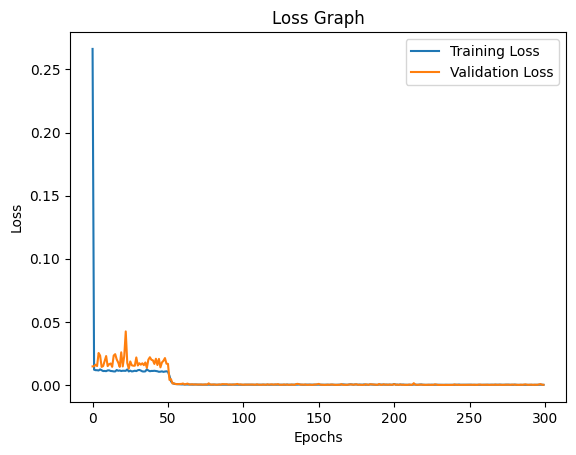

In [24]:
plt.plot(loss_graph)
plt.plot(val_graph)
plt.title("Loss Graph")
plt.legend(['Training Loss', 'Validation Loss'])
plt.xlabel("Epochs")
plt.ylabel("Loss")

### The next 3 cells are used for Hyper Parameter Sweeping using Wandb. Do not run these cells unless you are logged into Wandb and is doing hyper parameter sweep

In [11]:
sweep_config = {
    "method": "bayes",
    "metric": {
        "name": "val_loss",
        "goal": "minimize"
    },
    "parameters": {
        "learning_rate": {
            "min": 1e-3,
            "max": 0.01
        },
        "hidden_size": {
            "values": [64, 128, 256]
        },
        "num_epochs": {
            "values": [300, 500, 1000]
        },
        "num_layers":{
            "values": [1, 2, 3]
        }
    }
}

In [12]:
def sweep_train_transformer():
    wandb.init()
    config = wandb.config

    # Initialize your Transformer model
    model = TransformerModel(
        input_size=8,
        output_size=1,
        hidden_dim=config.hidden_size,
        num_heads=8,
        num_layers=config.num_layers,
    ).to(device)

    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=config.learning_rate)
    model.train()

    loss_graph = []
    val_graph = []

    for epoch in tqdm(range(config.num_epochs)):
        epoch_loss = 0
        for batch_idx, (inputs, targets) in enumerate(train_loader):
            inputs, targets = inputs.to(device), targets.to(device)

            # Forward pass
            output = model(inputs, tgt=targets)
            loss = criterion(output, targets)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
            epoch_loss += loss.item()

        avg_loss = epoch_loss / len(train_loader)
        loss_graph.append(avg_loss)

        # Validation
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for val_inputs, val_targets in val_loader:
                val_inputs, val_targets = val_inputs.to(device), val_targets.to(device)
                val_output = model(val_inputs, tgt=val_targets)
                val_loss += criterion(val_output, val_targets).item()
        avg_val_loss = val_loss / len(val_loader)
        val_graph.append(avg_val_loss)
        model.train()

        # W&B Logging
        wandb.log({
            "epoch": epoch,
            "train_loss": avg_loss,
            "val_loss": avg_val_loss
        })

        if epoch % 50 == 0:
            print(f"Epoch {epoch+1}/{config.num_epochs} | Train Loss: {avg_loss:.4f} | Val Loss: {avg_val_loss:.4f}")

    # Optional loss plot
    plt.plot(loss_graph)
    plt.plot(val_graph)
    plt.title("Transformer Loss Graph")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(["Training Loss", "Validation Loss"])
    plt.savefig("transformer_loss.png")
    wandb.log({"loss_plot": wandb.Image("transformer_loss.png")})

    return loss_graph, val_graph


In [ ]:
sweep_id = wandb.sweep(sweep_config, project="DeepLearning Project")
wandb.agent(sweep_id, function=sweep_train_transformer, count=30)

### The next 2 cells are used to save the last ran model and to load models. Do not run unless you are saving or loading models from file.

In [25]:
import os

# Create the 'models' directory if it doesn't exist
os.makedirs('./final_models', exist_ok=True)
torch.save(model.state_dict(), './final_models/transformer.pth')

In [26]:
import random

input_size = 8
hidden_size = 64
num_layers = 1
output_size = 1
num_heads = 8

# Initialize Seq2Seq Model
model = TransformerModel(input_size, output_size, num_heads, num_layers, hidden_dim = hidden_size).to(device)
model.load_state_dict(torch.load('./final_models/transformer.pth'))
seed_value = random.randint(0, 10000)

### The final cell here is used for evaluation

Normalized output[0]: [[0.5990742444992065], [0.6142412424087524], [0.6296035051345825]]
Normalized target[0]: [[0.6744818687438965], [0.7138973474502563], [0.6965681314468384]]
Denormalized output[0]: [[147.8856201171875], [151.49142456054688], [154.41026306152344]]
Denormalized target[0]: [[165.4166717529297], [175.0833282470703], [170.8333282470703]]
--------------------------------------------------
Normalized output[0]: [[0.398593008518219], [0.3971518278121948], [0.39629048109054565]]
Normalized target[0]: [[0.41182467341423035], [0.4145429730415344], [0.4444444477558136]]
Denormalized output[0]: [[98.04247283935547], [97.42548370361328], [97.19023895263672]]
Denormalized target[0]: [[101.0], [101.66666412353516], [109.0]]
--------------------------------------------------
Normalized output[0]: [[0.41291511058807373], [0.41370731592178345], [0.41534438729286194]]
Normalized target[0]: [[0.44648319482803345], [0.3978933095932007], [0.3560992181301117]]
Denormalized output[0]: [[10

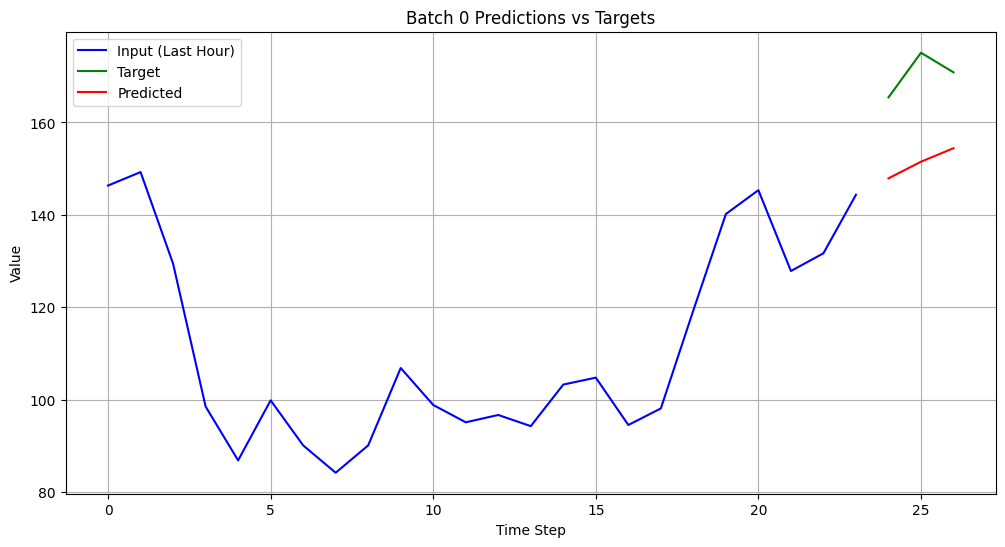

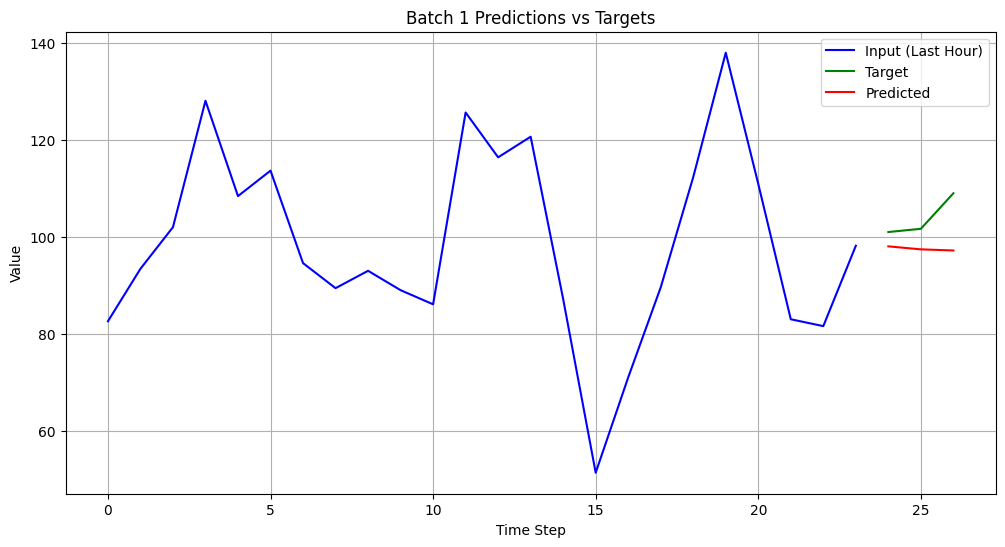

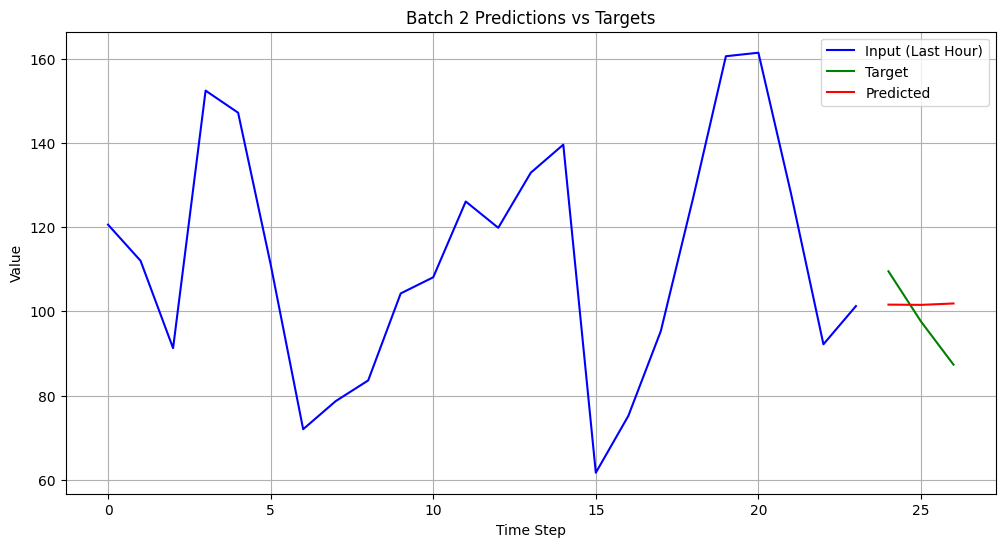

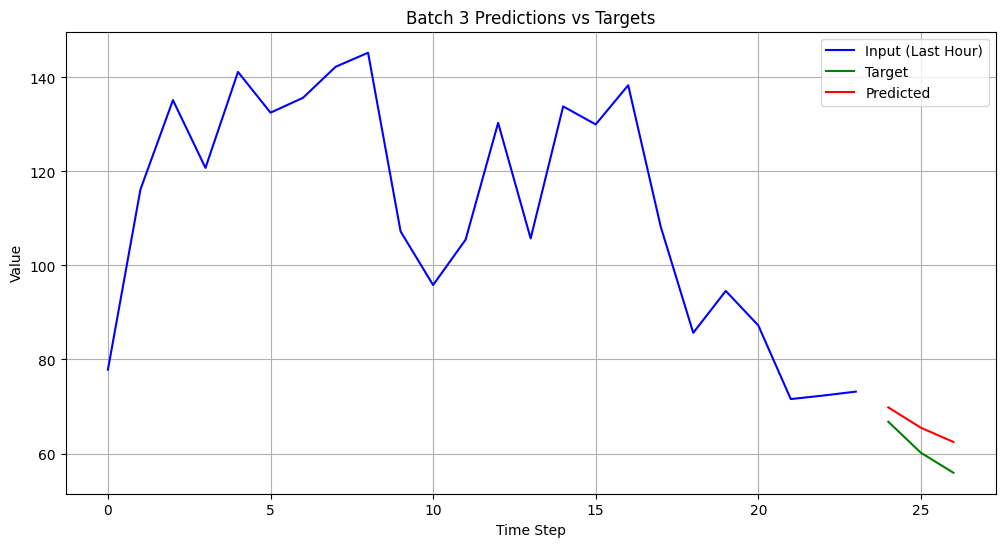

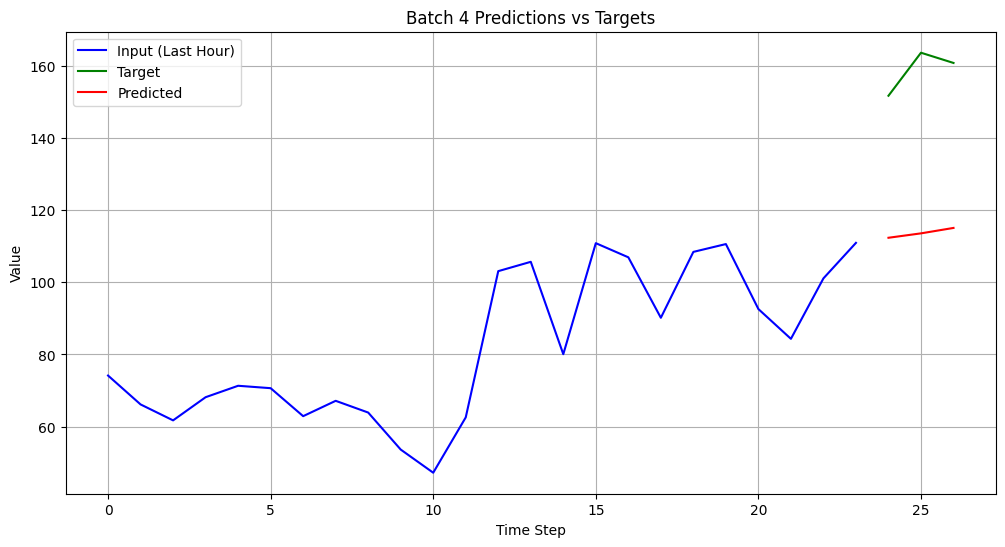

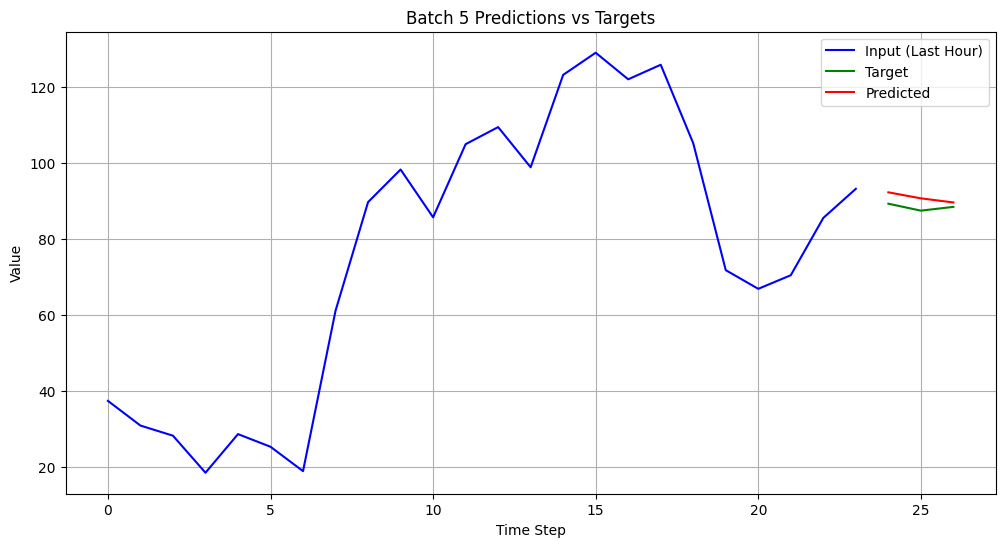

In [27]:
import collections
model.eval()  # Set the model to evaluation mode

# Initialize variables to track loss
loss_value = 0
num_batches = 0

# Define the loss function
criterion = torch.nn.MSELoss()
mae_list = []
visualise_dataset = collections.defaultdict(list)

# Disable gradient computation for validation
with torch.no_grad():
    for batch_idx, (inputs, targets) in enumerate(test_loader):

        # Move data to device
        inputs, targets = inputs.to(device), targets.to(device)  # inputs: [B, 24, 7], targets: [B, 3, 1]

        # Initialize decoder input with a fixed token, e.g., 0.0
        batch_size = inputs.size(0)
        tgt_input = inputs[:, -1:, 5:6]  # Feed in last input as first output

        # Autoregressive prediction
        for step in range(targets.size(1)):  # Predict 3 steps
            output = model(inputs, tgt=tgt_input)  # output: [B, current_step+1, 1]
            next_token = output[:, -1:, :]  # [B, 1, 1]
            tgt_input = torch.cat([tgt_input, next_token], dim=1)  # Grow decoder input

        # Skip the first token (initial start token)
        predicted = tgt_input[:, 1:, :]  # [B, 3, 1]

        # Denormalize predictions and targets
        inputs_denorm = inputs * (data_max["Average Taxi Availability"] - data_min["Average Taxi Availability"]) + data_min["Average Taxi Availability"]
        output_denorm = predicted * (data_max["Average Taxi Availability"] - data_min["Average Taxi Availability"]) + data_min["Average Taxi Availability"]
        targets_denorm = targets * (data_max["Average Taxi Availability"] - data_min["Average Taxi Availability"]) + data_min["Average Taxi Availability"]
        
        visualise_dataset[batch_idx] = inputs_denorm[:,:, 5:6].cpu().numpy()
        # Add targets to visualise_dataset
        visualise_dataset[batch_idx] = np.concatenate((visualise_dataset[batch_idx], targets_denorm.cpu().numpy()), axis=1)
        visualise_dataset[batch_idx] = np.concatenate((visualise_dataset[batch_idx], output_denorm.cpu().numpy()), axis=1)

        # Compute loss on normalized data
        loss_value += criterion(output, targets)
        mae = torch.mean(torch.abs(output_denorm - targets_denorm))
        mae_list.append(mae)

        # Print a sample of the normalized and denormalized values
        print("Normalized output[0]:", output[0].tolist())  
        print("Normalized target[0]:", targets[0].tolist())  
        print("Denormalized output[0]:", output_denorm[0].tolist())  
        print("Denormalized target[0]:", targets_denorm[0].tolist())  
        print("-" * 50)

# Compute average loss
loss_value = loss_value / (len(test_loader) - 1)
print(f'Average Validation Loss: {loss_value:.4f}')

mae = torch.mean(torch.tensor(mae_list))
print(f'Mean Absolute Error: {mae:.4f}')

# Visualize the predictions and targets for the first batch
for batch_idx, data in visualise_dataset.items():
    inputs = data[0, :24]       # First 25 timesteps
    targets = data[0, 24:27]    # 3 timesteps: ground truth
    predictions = data[0, 27:]  # 3 timesteps: model predictions
    plt.figure(figsize=(12, 6))
    # Input: plotted from timestep 0 to 24
    plt.plot(range(24), inputs[:, -1], label='Input (Last Hour)', color='blue')
    # Targets: plotted starting from timestep 24 to 26
    plt.plot(range(24, 27), targets[:, -1], label='Target', color='green')
    # Predictions: plotted from timestep 27 to 29
    plt.plot(range(24, 27), predictions[:, -1], label='Predicted', color='red')
    plt.title(f'Batch {batch_idx} Predictions vs Targets')
    plt.xlabel('Time Step')
    plt.ylabel('Value')
    plt.legend()
    plt.grid(True)
    plt.show()